# WIDS 2021 Datathon
Predicting Diabetes Mellitus <br>
Shilpa Narayan

In [2]:
from IPython.display import HTML
#https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>''')

In [1]:
## import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
import missingno as msno
from numpy import isnan
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report,accuracy_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.impute import SimpleImputer
from numpy import nan
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC

sns.set() # will create pretty matplots
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#global format settigns for plots
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'
plt.rcParams['font.size']=12
warnings.filterwarnings('ignore')
pd.set_option('precision', 3) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.3f}'.format) # get rid of scientific notation

## Functions

In [78]:
##Functions used later

## identify categorical columns
# https://pbpython.com/categorical-encoding.html
def identifyCatVar(df):
    cat_df = df.select_dtypes(include = ['object']).copy()
    cat_df.head()
    return cat_df

#Function to summarize the number of rows with missing values for each column

def summarizeMissing(df):
    missing_df = []
    columns=['Variable','Missing','Percent']
    for i in range(df.shape[1]):
        # count number of rows with missing values
        n_miss = df.iloc[:,i].isnull().sum()
        perc = n_miss / df.shape[0] * 100
        values = [i,n_miss,perc]
        zipped = zip(columns, values)
        dict_miss = dict(zipped)
        missing_df.append(dict_miss)
    return missing_df
#Function to replace NAN values with mode value
def impute_nan_most_frequent_category(DataFrame,ColName):
    # .mode()[0] - gives first category name
     most_frequent_category=DataFrame[ColName].mode()[0]
    # replace nan values with most occured category
     DataFrame[ColName].fillna(most_frequent_category,inplace=True)


#https://stackoverflow.com/questions/56088264/trouble-training-xgboost-on-categorical-column
#Function to convert categories to strings so that XGBClassfier works
def catToString(X):
    df = identifyCatVar(X)
    lbl = preprocessing.LabelEncoder()
    for i in df.columns:
        X[i] = lbl.fit_transform(X[i].astype(str))
    return X

def callROC_Curve(y_pred_prob,y_train):
    # keep probabilities for the positive outcome only
    y_pred_prob = y_pred_prob[:,1]
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
    best_thresh = getoptimalThreshold(fpr,tpr,thresholds,y_pred_prob,y_train)
    plt.show()
    return best_thresh

def exploreConfusionMatrix(y_pred,y_pred_prob,y,threshold):
    threshold = float(threshold)
    #y_pred = fit.predict_proba(X)
    # keep probabilities for the positive outcome only
    y_pred_prob = y_pred_prob[:,1]
    pred = [ 0 if x < threshold else 1 for x in y_pred_prob]
    print("\nConfusion Matrix for Threshold=%.3f" %threshold+"\n")
    metrics = getClassificationMetrics(y_pred,y_pred_prob,y,threshold)
    return pd.DataFrame(metrics)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs > threshold).astype('int')

#computes optimal threshold based on f1 score. Called from CallROC_Curve
def getoptimalThreshold(fpr, tpr,thresholds, probs,y_train):
    #the function creates a f1 score for the data using al lthe thresholds
    scores_t = [f1_score(y_train, to_labels(probs, t)) for t in thresholds]
    # get index of best threshold with max score
    ix = np.argmax(scores_t)
    print('\nBest Threshold=%.3f, F-Score=%.3f' % (thresholds[ix], scores_t[ix]))
    #sets limits for axis
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    #plot the fpr and tpr for the model
    plt.plot(fpr, tpr, marker='.', label='Model')
    #plot the best threshold point
    plt.scatter(fpr[ix], tpr[ix], marker='D', color='black', label='Best')
    #set labels and legend
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    #return the best threshold based on the f1score
    return thresholds[ix]

#Mainly used to fill the final table of metrics exactly as asked and plot the confusion matrix(cm) where required
#takes the best estimator and any x and y values alogn with a threshold to compute the metrics and cm. used in exploreConfusionMatrix function
def getClassificationMetrics(y_pred, pred_prob, y_test,threshold):
    #compute predicted probabilities
    #pred_prob = fit.predict_proba(X)
    #keep probabilities for the positive outcome only
    #pred_prob = pred_prob[:,1]
    CM = confusion_matrix(y_test,y_pred)
    TN = CM[0][0]; FN = CM[1][0] ; TP = CM[1][1]; FP = CM[0][1]
    Population = TN+FN+TP+FP
    Accuracy   = round( ((TP+TN)*100) / Population,2)
    Accuracy = str(Accuracy)+'%'
    Recall     = round( TP / (TP+FN),4 )
    FPR        = round( FP / (TN+FP),4 )
    Specificity = 1-FPR
    FDR        = round( FP / (TP+FP),4 )
    Precision  = round( TP / (TP+FP),4 )
    auc = roc_auc_score(y_test, pred_prob)
    plt.title('Confusion Matrix')
    #get values from the confusion matrix inbuilt function and use it in a seaborn plot to make it look pretty
    sns.heatmap( pd.DataFrame(CM, columns=['Predicted Negative', 'Predicted Positive'], index=['Negative', 'Positive']), annot=True, cmap='Blues',fmt="")
    plt.show()
    #store metrics in a data frame and return. This format will eb useful to plot the final table
    metrics = pd.DataFrame({
        'Metrics':['Accuracy','AUC','Threshold','Recall','Specificity','FDR', 'Precision'],'Value':[Accuracy,auc,threshold,Recall,Specificity,FDR, Precision]})
    metrics = metrics.set_index('Metrics')
    return metrics

## Read Dataset and Clean Dataset

In [80]:
#read the training data set
df = pd.read_csv("Data_Files\TrainingWiDS2021.csv") 
#drop the duplicate index column
df = df.drop(columns=df.columns[0]) # removing unnamed column index

In [81]:
#print missing value summary
pd.DataFrame(summarizeMissing(df))

,Variable,Missing,Percent
0,0,0,0.000
1,1,0,0.000
2,2,4988,3.832
3,3,4490,3.450
4,4,0,0.000
...,...,...,...
175,175,0,0.000
176,176,0,0.000
177,177,0,0.000
178,178,0,0.000


In [83]:
# drop columns with > 80% missing values
pct_null = df.isnull().sum() / len(df)
missing_features = pct_null[pct_null > 0.80].index
df.drop(missing_features, axis=1, inplace=True)

In [84]:
#checkshape of new dataframe after dropping columns with >80% missing values
print(df.shape)
pd.DataFrame(summarizeMissing(df))

(130157, 148)


,Variable,Missing,Percent
0,0,0,0.000
1,1,0,0.000
2,2,4988,3.832
3,3,4490,3.450
4,4,0,0.000
...,...,...,...
143,143,0,0.000
144,144,0,0.000
145,145,0,0.000
146,146,0,0.000


## Impute missing categorical values

In [7]:
#create a copy of the dataframe to impute dategorical columns missing values
cat_impute_df = identifyCatVar(df)
#Call function to impute with most occured category
for Columns in cat_impute_df.columns.to_list():
    impute_nan_most_frequent_category(cat_impute_df,Columns)

In [8]:
#drop the categorical columsn to impute numericalvalues
num_impute_df= df.drop(columns=cat_impute_df.columns.to_list())

## Impute missing numerical values

In [9]:
''' Optional
#Better way to impute numerical values but takes a very long tiem for a large dataset
#https://towardsdatascience.com/preprocessing-regression-imputation-of-missing-continuous-values-f612179bafb4
#https://towardsdatascience.com/3-underrated-strategies-to-deal-with-missing-values-a539fb6c0690
imputer = IterativeImputer(ExtraTreesRegressor(),random_state=13)
values = cat_impute_df.values
impute_data = pd.DataFrame(imputer.fit_transform(values))
# count the number of NaN values in each column
summarizeMissing(impute_data)
'''

' Optional\n#Better way to impute numerical values but takes a very long tiem for a large dataset\n#https://towardsdatascience.com/preprocessing-regression-imputation-of-missing-continuous-values-f612179bafb4\n#https://towardsdatascience.com/3-underrated-strategies-to-deal-with-missing-values-a539fb6c0690\nimputer = IterativeImputer(ExtraTreesRegressor(),random_state=13)\nvalues = cat_impute_df.values\nimpute_data = pd.DataFrame(imputer.fit_transform(values))\n# count the number of NaN values in each column\nsummarizeMissing(impute_data)\n'

In [85]:
#another imputing technicque based on mean, median, most_frequent 
#all vlaues give same results. therefore going with most_frequent
imputer_s = SimpleImputer(missing_values=nan, strategy='most_frequent')
# transform the dataset
impute_data = pd.DataFrame(imputer_s.fit_transform(num_impute_df))
# count the number of NaN values in each column
pd.DataFrame(summarizeMissing(impute_data))

,Variable,Missing,Percent
0,0,0,0.000
1,1,0,0.000
2,2,0,0.000
3,3,0,0.000
4,4,0,0.000
...,...,...,...
137,137,0,0.000
138,138,0,0.000
139,139,0,0.000
140,140,0,0.000


## Merge back final imputed dataset

In [10]:
#create new dataframe with imputed data and combine with categorical variables to create final imputed dataset
impute_data.columns = num_impute_df.columns
final_data = pd.concat([impute_data,cat_impute_df],axis=1)
final_data.shape

(130157, 148)

In [11]:
#make sure final_dataset looks good
final_data.head(5)

,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,...,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,"214,826.000",118.000,68.000,22.733,0.000,180.300,92.000,0.542,0.000,73.900,...,0.000,0.000,0.000,1.000,Caucasian,M,Floor,Floor,admit,CTICU
1,"246,060.000",81.000,77.000,27.422,0.000,160.000,90.000,0.928,0.000,70.200,...,0.000,0.000,0.000,1.000,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
2,"276,985.000",118.000,25.000,31.953,0.000,172.700,93.000,0.001,0.000,95.300,...,0.000,0.000,0.000,0.000,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
3,"262,220.000",118.000,81.000,22.636,1.000,165.100,92.000,0.001,0.000,61.700,...,0.000,0.000,0.000,0.000,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU
4,"201,746.000",33.000,19.000,67.815,0.000,188.000,91.000,0.074,0.000,68.000,...,0.000,0.000,0.000,0.000,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU


## Create dependent and independent variables to run classification with train and test data

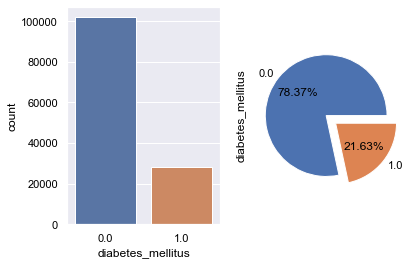

<Figure size 288x288 with 0 Axes>

In [16]:
#https://www.kaggle.com/celniker/wids2021-initial-eda-and-tuned-lgbm-0-86293
#Checking proportion of data
fig, ax =plt.subplots(1,2)
plt.figure(figsize=(4,4))                                                
sns.countplot('diabetes_mellitus',data=final_data,ax=ax[0])
final_data['diabetes_mellitus'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.2f%%',ax=ax[1])
fig.show()

In [17]:
#create X and Y from final dataset
#https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html
#convert categorical data to strings
final_data = catToString(final_data,)

#create X and Y
X = final_data.drop(final_data[['diabetes_mellitus']],axis=1)
Y = final_data[['diabetes_mellitus']]
#create train and test set to check accuracy, using stratify as the data is imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.70,stratify=Y,random_state=1)

## Logistic Regression to compare with XGBoost

In [14]:
## Logistic Regression with cross validation
# we must apply the scaling to the test set that we computed for the training set
clf_lr = linear_model.LogisticRegressionCV(cv=5, random_state=1).fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: %.2f%%' %(clf_lr.score(X_test, y_test)*100))

Accuracy of logistic regression classifier on test set: 80.79%


## XGBoost

In [18]:
#https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# fit model on all the training data and check accuracy
model_fs = xgb.XGBClassifier(verbosity=0)
model_fs.fit(X_train, y_train);
# make predictions for test data and evaluate
pred_fs = model_fs.predict(X_test)
accuracy = accuracy_score(y_test, pred_fs)
print("\n\nAccuracy with 147 features: %.2f%%" % (accuracy * 100.0))



Accuracy with 147 features: 83.67%


In [22]:
#https://mljar.com/blog/feature-importance-xgboost/
##Feature Selection using XGB
#create a subset of data removing thsoe features with importance 0
sorted_idx = model_fs.feature_importances_.argsort()
feature_imp = pd.DataFrame(X.columns[sorted_idx], model_fs.feature_importances_[sorted_idx])
feature_imp = feature_imp.reset_index()
feature_imp.columns=['importance','features']
reduced_data = final_data[feature_imp[feature_imp["importance"] > 0].features.values.tolist()]

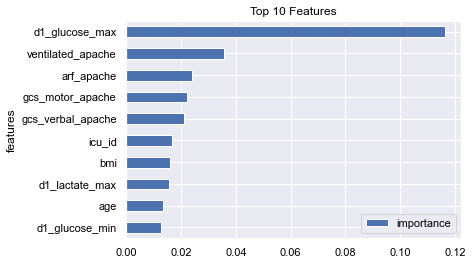

In [23]:
#Top 10 features
feature_imp= feature_imp.set_index('features')
feature_imp.tail(10).plot.barh(title='Top 10 Features');

In [24]:
#change categorical variables to strings in the reduced dataset
reduced_data = catToString(reduced_data)

In [25]:
#create new training and test data with reduced data and check accuracy
X_train_rd, X_test_rd, y_train, y_test = train_test_split(reduced_data, Y, train_size=0.70,stratify=Y,random_state=1)
model_rd = xgb.XGBClassifier(verbosity=0)
model_rd.fit(X_train_rd, y_train)
# make predictions for test data and evaluate
pred_rd = model_rd.predict(X_test_rd)
accuracy_rd = accuracy_score(y_test, pred_rd)
print("\n\nAccuracy with 139 features: %.2f%%" % (accuracy_rd * 100.0))



Accuracy with 139 features: 83.67%


## Hyper parameter tuning for XGBOOST

In [26]:
#Takes forever to run so skip if you don't have tiem to run this and just see the results
#https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a
#Perform hyperparameter tunign on reduced data to save time
# Define our search space for grid search
#peforming on 3 splits in interest of time
kfold = StratifiedKFold(n_splits=3, random_state=1,shuffle=True)
# Create a pipeline
pipe = Pipeline([
('scaler', StandardScaler()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic',verbosity=0))
])
search_space = [
  {
    'clf__n_estimators': [150,200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)]
  }
]
# AUC and accuracy as score
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC'
)
# Fit grid search
model = grid.fit(X_train_rd, y_train)

## ROC and AUC

Best Params:  {'clf__colsample_bytree': 0.2, 'clf__gamma': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200}

Best Threshold=0.351, F-Score=0.721


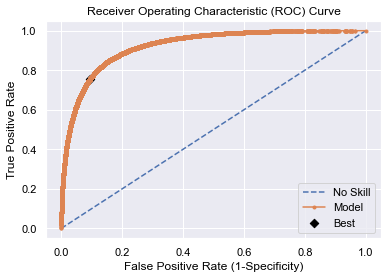


Confusion Matrix for Threshold=0.351



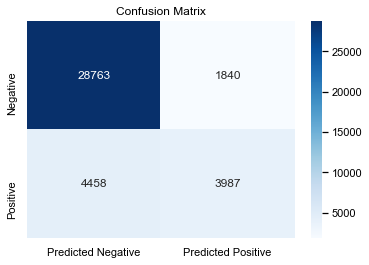

,Value
Metrics,
Accuracy,83.87%
AUC,0.867
Threshold,0.351
Recall,0.472
Specificity,0.940
FDR,0.316
Precision,0.684


In [27]:
#predict using the best model
#focusing on accuracy and default threshold
print('Best Params: ', model.best_params_)
##ROC Curve
#find best threshold to use on test dataset
#finding threshold on training data takes a long time
predict = model.predict(X_test_rd)
y_pred_tr = model.predict_proba(X_train_rd)
thresh = callROC_Curve(y_pred_tr,y_train)
#use threshold now on test set to get metrics
y_pred_prob_test = model.predict_proba(X_test_rd)
exploreConfusionMatrix(predict, y_pred_prob_test,y_test,thresh)

## Applying the best model to the hold out dataset for submission

In [28]:
#applying model to hold out data
HO = pd.read_csv('Data_files/UnlabeledWiDS2021.csv')
HO = HO.drop(columns=HO.columns[0]) # removing unnamed column index
# keep columns in train
X_HO = HO[reduced_data.columns]
#convert categories to strings
X_HO = catToString(X_HO)
#we do not know y_HO

In [29]:
#predict probabilities on submission hold out data
predict_HO = model.predict_proba(X_HO)
submission_df = pd.DataFrame(predict_HO[:,1].round(3),HO.encounter_id)
submission_df = submission_df.sort_values('encounter_id')
submission_df.columns=['diabetes_mellitus']
#submission_df = submission_df.reset_index()
#create submission csv
submission_df.to_csv("wids2021_choksi_huilin_leonard_narayan.csv")

In [54]:
#check contents to make sure
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10234 entries, 135000 to 146000
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diabetes_mellitus  10234 non-null  float32
dtypes: float32(1)
memory usage: 119.9 KB


In [55]:
submission_df.tail()

,diabetes_mellitus
encounter_id,
145996,0.325
145997,0.097
145998,0.278
145999,0.068
146000,0.341
